# Classifier Methods Lasso Regularization Evaluation

<div class="alert alert-block alert-warning">
  
<b>Notebook objectives:</b>
    
* Evaluate the effect of Lasso regularized variables in classfier methods predictions
    

# 1. Notebook set up

In [ ]:
# if xgboost throws and error uncomment and install xgboost package and reset kernel
# !pip install xgboost

In [1]:
# install packages if error occurs and reset kernel
# !pip install imblearn

In [1]:
# Try downgrading pandas version if pickle throws an error while loading
# !pip install pandas==1.4.1

In [1]:
###### Import packages

### Data handling
import numpy as np
import pandas as pd
import datetime as dt
#from IPython.display import HTML, Image #display formatted texts
import warnings
warnings.filterwarnings('ignore')

### Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn') # pretty graphs
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Files to pickle
import pickle
import bz2
import _pickle as cPickle

### sampling
from sklearn.model_selection import train_test_split

### sk-learn pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


### Model selection

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# if xgboost throws and error uncomment and install xgboost package
# !pip install xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz

# Imbalancer Learn Pipeline
from imblearn.pipeline import Pipeline, make_pipeline

# Class Imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule, InstanceHardnessThreshold, TomekLinks
from collections import Counter

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Scoring
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, average_precision_score, f1_score, make_scorer
from sklearn.inspection import partial_dependence

### Scipy stats
from scipy.stats import loguniform

### Time progress bar
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import time

# Google path set up
pickles = "/content/drive/MyDrive/pickles/"
pickles_w1 = "/content/drive/MyDrive/pickles/w1/"
pickles_w2 = "/content/drive/MyDrive/pickles/w2/"
pickles_w3 = "/content/drive/MyDrive/pickles/w3/"
pickles_w4 = "/content/drive/MyDrive/pickles/w4/"
pickles_w5 = "/content/drive/MyDrive/pickles/w5/"
pickles_imbalance = "/content/drive/MyDrive/pickles/class_imbalance_learn/"
pickles_tuning = "/content/drive/MyDrive/pickles/tuning/"

# Path set up
path = "/project/data/"
path_w1 = "/project/data/w1/"
path_w2 = "/project/data/w2/"
path_w3 = "/project/data/w3/"
path_w4 = "/project/data/w4/"
path_w5 = "/project/data/w5/"
json_path = "/project/notebooks/map/KEYFILE.json"
path_feature = "/project/data/feature_importance/"
path_imbalance = "/project/data/class_imbalance_learn/"
path_tuning = "/project/data/tuning/"

# fixed values
seed = 2323
colors = {'c1':['blue', 'red'], 'c2': ['red', 'blue', 'grey', 'purple']}
bar_width = 0.3
bin_num = 25
size = {'small_tick': 9, 'tick': 10 , 'label': 14, 'sub_title': 16, 'main_title': 20}
fig_size = {'large': (30,25), 'small': (10, 5)}

# pandas display set up
pd.options.display.max_columns = None

# 2. Loading pre-processed 'X' and 'y'

In [2]:
# Loading X
pickled_data_X = bz2.BZ2File(path_feature + 'X_train_regularized_w2_1pct', 'rb')
X_train_lasso = cPickle.load(pickled_data_X)
pickled_data_X.close()
print(F"X_train shape: rows {X_train_lasso.shape[0]}, columns {X_train_lasso.shape[1]}")

X_train shape: rows 338282, columns 189


In [3]:
# Loading y (target)
pickled_data_y = bz2.BZ2File(path_feature + 'y_train_regularized_w2_1pct', 'rb')
y_train_lasso = cPickle.load(pickled_data_y)
pickled_data_y.close()
print(F"y_train shape: rows {y_train_lasso.shape[0]}, columns 1")
# y_train = np.array(y_train)

y_train shape: rows 338282, columns 1


In [4]:
# Loading X test
pickled_data_X = bz2.BZ2File(path_feature + 'X_test_regularized_w2_1pct', 'rb')
X_test_lasso = cPickle.load(pickled_data_X)
pickled_data_X.close()
print(F"X_train shape: rows {X_test_lasso.shape[0]}, columns {X_test_lasso.shape[1]}")

X_train shape: rows 59697, columns 189


In [5]:
# Loading y test
pickled_data_y = bz2.BZ2File(path_feature + 'y_test_regularized_w2_1pct', 'rb')
y_test_lasso = cPickle.load(pickled_data_y)
pickled_data_y.close()
print(F"y_train shape: rows {y_test_lasso.shape[0]}, columns 1")
# y_train = np.array(y_train)

y_train shape: rows 59697, columns 1


### 2.1 Class imbalance over and under sampling

From testing class imbalance methods, there's evidence that applying over and under sampling generate an easier to comprenhed decisoin boundary which translates in a higher recall score (i.e., higher classificaction power on the target class). Thus, a pipeline of an over and under sampling method is defined to conduct hyperparameter tuning.


In [6]:
# Define pipeline
#over_sampler = RandomOverSampler(sampling_strategy=0.05, random_state = seed)
over_sampler = SMOTE(k_neighbors=8, sampling_strategy=0.1, random_state = seed)
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state = seed)

steps = [('over', over_sampler), ('under', under_sampler)]
pipeline_imbalance_methods = Pipeline(steps=steps)

In [7]:
# Run over and under sample pipeline
X_resampled, y_resampled = pipeline_imbalance_methods.fit_resample(X_train_lasso,y_train_lasso)

In [8]:
# Define and fit over sampling method SMOTE
SMOTE_over = SMOTE(k_neighbors=8, random_state = seed)
X_over, y_over = SMOTE_over.fit_resample(X_train_lasso,y_train_lasso)

In [9]:
# Define and fit over sampling method ADASYN
ADASYN_over = ADASYN(n_neighbors=8, random_state = seed)
X_over_2, y_over_2 = ADASYN_over.fit_resample(X_train_lasso,y_train_lasso)

# 3. Model definition

### Logistic Regression

In [10]:
# defining ligistic regression
clf_1 = LogisticRegression(random_state = seed)

In [11]:
clf_1.fit(X_train_lasso, y_train_lasso)

LogisticRegression(random_state=2323)

In [17]:
# load tuned params
clf_1_tuned_params = pd.read_csv(path_tuning + 'clf1_grid_best.csv')

# Defining tuned classifier Logistic Regression
clf_1_tuned = LogisticRegression(C = clf_1_tuned_params['C'][0], 
                           penalty = clf_1_tuned_params['penalty'][0], 
                           solver = clf_1_tuned_params['solver'][0],
                           random_state = seed)

# Fitting tuned classifier LR
clf_1_tuned.fit(X_train_lasso, y_train_lasso)

LogisticRegression(C=0.01, random_state=2323, solver='newton-cg')

### Bayes Naives Classifier

In [12]:
clf_2 = GaussianNB()

In [13]:
clf_2.fit(X_train_lasso, y_train_lasso)

GaussianNB()

In [16]:
# load tuned params
clf_2_tuned_params = pd.read_csv(path_tuning + 'clf2_rand_best.csv')

# define tuned classifier GNB
clf_2_tuned = GaussianNB(var_smoothing=round(clf_2_tuned_params['var_smoothing'][0],2))

# fit tuned classifier GNB
clf_2_tuned.fit(X_train_lasso, y_train_lasso)

GaussianNB(var_smoothing=2.77)

### Random Forest

In [14]:
# defining Random Forest
clf_3 = RandomForestClassifier(random_state = seed)

In [15]:
clf_3.fit(X_train_lasso, y_train_lasso)

RandomForestClassifier(random_state=2323)

In [18]:
# load tuned params
clf_3_tuned_params = pd.read_csv(path_tuning + 'clf3_rand_best.csv')

# Define tuned classifier RF
clf_3_tuned = RandomForestClassifier(criterion = clf_3_tuned_params['criterion'][0], 
                               max_depth = round(clf_3_tuned_params['max_depth'][0],0), 
                               n_estimators = clf_3_tuned_params['n_estimators'][0], 
                               random_state = seed)

# Fit tuned classifier RF
clf_3_tuned.fit(X_train_lasso, y_train_lasso)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=110,
                       random_state=2323)

### AdaBoost Classifier

In [19]:
clf_4 = AdaBoostClassifier(random_state = seed)

In [20]:
clf_4.fit(X_train_lasso, y_train_lasso)

AdaBoostClassifier(random_state=2323)

In [21]:
# load tuned params
clf_4_tuned_params = pd.read_csv(path_tuning + 'clf4_rand_best.csv')

# Define tuned classifier Adaboost
clf_4_tuned = AdaBoostClassifier(n_estimators = clf_4_tuned_params['n_estimators'][0], 
                           learning_rate = round(clf_4_tuned_params['learning_rate'][0],2), 
                           random_state = seed)

# Fit tuned classifier AdaBoost
clf_4_tuned.fit(X_train_lasso, y_train_lasso)

AdaBoostClassifier(learning_rate=1, random_state=2323)

### QD Classifier

In [22]:
clf_5 = QuadraticDiscriminantAnalysis() 

In [23]:
clf_5.fit(X_train_lasso, y_train_lasso)

QuadraticDiscriminantAnalysis()

In [24]:
# load tuned params
clf_5_tuned_params = pd.read_csv(path_tuning + 'clf5_rand_best.csv')

# Define tuned classifier QC
clf_5_tuned = QuadraticDiscriminantAnalysis(tol= clf_5_tuned_params['tol'][0]) 

# Fit tuned classifier QC
clf_5_tuned.fit(X_train_lasso, y_train_lasso)

QuadraticDiscriminantAnalysis(tol=0.0009781537691938)

### MLP Classifier

In [25]:
clf_6 = MLPClassifier(max_iter=100, random_state = seed)

In [26]:
clf_6.fit(X_train_lasso, y_train_lasso)

MLPClassifier(max_iter=100, random_state=2323)

In [27]:
# load tuned params
clf_6_tuned_params = pd.read_csv(path_tuning + 'clf6_rand_best.csv')

# Define tuned classifier MLP
clf_6_tuned = MLPClassifier(hidden_layer_sizes = (50, 100, 50),
                      activation = clf_6_tuned_params['activation'][0],
                      alpha = round(clf_6_tuned_params['alpha'][0],2),
                      random_state = seed)

# Fit tuned classifier MLP
clf_6_tuned.fit(X_train_lasso, y_train_lasso)

MLPClassifier(alpha=0.13, hidden_layer_sizes=(50, 100, 50), random_state=2323)

### XGBoost Classifier

In [28]:
# defining XGB Classifier
clf_7 = XGBClassifier(learning_rate = 0.02, 
                          n_estimators = 100,
                          objective = 'binary:logistic',
                          silent = True, 
                          nthread = 1,
                          max_depth = 4,
                          verbosity = 0,
                          random_state = seed)

In [29]:
clf_7.fit(X_train_lasso, y_train_lasso)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=2323, reg_alpha=0, ...)

In [30]:
# Load tuned params
clf_7_tuned_params = pd.read_csv(path_tuning + 'clf7_rand_best.csv')

# Define tuned classifier XGBoost
clf_7_tuned = XGBClassifier(learning_rate = round(clf_7_tuned_params['learning_rate'][0],2), 
                          n_estimators = clf_7_tuned_params['n_estimators'][0],
                          objective = 'binary:logistic',
                          silent = True, 
                          nthread = 1,
                          max_depth = clf_7_tuned_params['max_depth'][0],
                          verbosity = 0,
                          scale_pos_weight = clf_7_tuned_params['scale_pos_weight'][0], #1400, #1700
                          random_state = seed)

# Fit tuned classifier
clf_7_tuned.fit(X_train_lasso,y_train_lasso)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=2323, reg_alpha=0, ...)

# 4. Further tuning best performing classifier

#### Random Forest

In [49]:
##### Grid search for classifier

# Defining classifier
classifier = clf_3

# Define hyperparameter search space
criterion = ['gini']
max_depth = [10, 50, 100]
n_estimators = [10, 50, 100]
class_weight= ['balanced', 'balanced_subsample']

search_space_clf3 = dict(max_depth=max_depth, n_estimators=n_estimators, criterion=criterion, class_weight=class_weight)

scoring = {'auc': 'roc_auc', 'recall':'recall', 'precision': 'precision'}

# scoring = {'auc' : make_scorer(roc_auc_score, needs_proba = True, average = 'macro'),
#            'recall' : make_scorer(recall_score, average = 'macro')}
           
# Define grid search
kfold_cv = StratifiedKFold(n_splits = 2, random_state = seed, shuffle = True)
grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=search_space_clf3, 
                           cv=kfold_cv, 
                           n_jobs=-1, 
                           scoring=scoring, 
                           refit='auc', 
                           verbose = 10) #scoring, refit='auc',
grid_result = grid_search.fit(X_train_lasso, y_train_lasso)

# Get results
best_res_clf3_grid_over = grid_result.best_score_
best_params_clf3_grid_over = grid_result.best_params_
mean_auc_clf3_grid_over = grid_result.cv_results_['mean_test_auc']
std_auc_clf3_grid_over = grid_result.cv_results_['std_test_auc']
mean_rec_clf3_grid_over = grid_result.cv_results_['mean_test_recall']
std_rec_clf3_grid_over = grid_result.cv_results_['std_test_recall']
params_clf3_grid_over = grid_result.cv_results_['params']

print(F"Best auc score: {grid_result.best_score_:.4%}\nBest parameters: {grid_result.best_params_}")

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best auc score: 65.3730%
Best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}


In [50]:
##### Export grid search results

# Define results as dfs
# sumamry df
clf3_grid_summary_lasso = pd.DataFrame()
clf3_grid_summary_lasso['mean_auc'] = list(mean_auc_clf3_grid_over)
clf3_grid_summary_lasso['std_auc'] = list(std_auc_clf3_grid_over)
clf3_grid_summary_lasso['mean_recall'] = list(mean_rec_clf3_grid_over)
clf3_grid_summary_lasso['std_recall'] = list(std_rec_clf3_grid_over)

clf3_grid_search_values_lasso = pd.DataFrame(params_clf3_grid_over)
clf3_grid_summary_lasso['criterion'] = clf3_grid_search_values_lasso['criterion']
clf3_grid_summary_lasso['max_depth'] = clf3_grid_search_values_lasso['max_depth']
clf3_grid_summary_lasso['n_estimators'] = clf3_grid_search_values_lasso['n_estimators']
clf3_grid_summary_lasso['n_estimators'] = clf3_grid_search_values_lasso['n_estimators']
clf3_grid_summary_lasso['class_weight'] = clf3_grid_search_values_lasso['class_weight']


# Best hyper-parameters
clf3_grid_best_lasso = pd.DataFrame([best_params_clf3_grid_over])

clf_export = [('clf3_grid_summary_lasso',clf3_grid_summary_lasso),
              ('clf3_grid_best_lasso',clf3_grid_best_lasso), 
              ('clf3_grid_search_values_lasso',clf3_grid_search_values_lasso)]

# Export to csv
for df in clf_export:
    df[1].to_csv(path_tuning + df[0]+'.csv', index = True, index_label = False)

In [52]:
##### Random search for classifier

# Defining classifier
classifier = clf_3

# Define hyperparameter search space
criterion = ['gini']
max_depth = range(10, 50, 5)
n_estimators = range(100, 150, 10)
class_weight= ['balanced_subsample']


search_space_clf3 = dict(criterion=criterion, max_depth=max_depth, n_estimators=n_estimators, class_weight=class_weight)

scoring = {'auc': 'roc_auc', 'recall':'recall', 'precision': 'precision'}

# scoring = {'auc' : make_scorer(roc_auc_score, needs_proba = True, average = 'macro'),
#            'recall' : make_scorer(recall_score, average = 'macro')}

           
# Define random search
kfold_cv = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True)
random_search = RandomizedSearchCV(estimator=classifier, 
                                   param_distributions = search_space_clf3, 
                                   cv = kfold_cv, 
                                   n_iter=10, 
                                   n_jobs=-1, 
                                   scoring=scoring, 
                                   refit='auc', 
                                   verbose = 10) #scoring, refit='auc',

random_result = random_search.fit(X_train_lasso, y_train_lasso)

# Get results
best_res_clf3_rand_over = random_result.best_score_
best_params_clf3_rand_over = random_result.best_params_
mean_auc_clf3_rand_over = random_result.cv_results_['mean_test_auc']
std_auc_clf3_rand_over = random_result.cv_results_['std_test_auc']
mean_rec_clf3_rand_over = random_result.cv_results_['mean_test_recall']
std_rec_clf3_rand_over = random_result.cv_results_['std_test_recall']
params_clf3_rand_over = random_result.cv_results_['params']


print(F"Best auc score random: {random_result.best_score_:.4%}\nBest parameters random: {random_result.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best auc score random: 66.7460%
Best parameters random: {'n_estimators': 120, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}


In [53]:
##### Export random search results

# Define results as dfs
# sumamry df
clf3_rand_summary_lasso = pd.DataFrame()
clf3_rand_summary_lasso['mean_auc'] = list(mean_auc_clf3_rand_over)
clf3_rand_summary_lasso['std_auc'] = list(std_auc_clf3_rand_over)
clf3_rand_summary_lasso['mean_recall'] = list(mean_rec_clf3_rand_over)
clf3_rand_summary_lasso['std_recall'] = list(std_rec_clf3_rand_over)

clf3_rand_search_values_lasso = pd.DataFrame(params_clf3_rand_over)
clf3_rand_summary_lasso['criterion'] = clf3_rand_search_values_lasso['criterion']
clf3_rand_summary_lasso['max_depth'] = clf3_rand_search_values_lasso['max_depth']
clf3_rand_summary_lasso['n_estimators'] = clf3_rand_search_values_lasso['n_estimators']
clf3_rand_summary_lasso['class_weight'] = clf3_rand_search_values_lasso['class_weight']


# Best hyper-parameters
clf3_rand_best_lasso = pd.DataFrame([best_params_clf3_rand_over])

clf_export = [('clf3_rand_summary_lasso',clf3_rand_summary_lasso),
              ('clf3_rand_best_lasso',clf3_rand_best_lasso), 
              ('clf3_rand_search_values_lasso',clf3_rand_search_values_lasso)]

# Export to csv
for df in clf_export:
    df[1].to_csv(path_tuning + df[0]+'.csv', index = True, index_label = False)

In [31]:
# load tuned params
clf_3_tuned_params_lasso = pd.read_csv(path_tuning + 'clf3_rand_best_lasso.csv')

# Define tuned classifier RF
clf_3_tuned_lasso = RandomForestClassifier(criterion = clf_3_tuned_params_lasso['criterion'][0], 
                               max_depth = round(clf_3_tuned_params_lasso['max_depth'][0],0), 
                               n_estimators = clf_3_tuned_params_lasso['n_estimators'][0],
                               class_weight = clf_3_tuned_params_lasso['class_weight'][0],
                               random_state = seed)

# Fit tuned classifier RF
clf_3_tuned_lasso.fit(X_train_lasso, y_train_lasso)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=120, random_state=2323)

#### XGBoost Classifier

In [56]:
##### Grid search for classifier

# Defining classifier
classifier = clf_7

max_depth = [100]
n_estimators = [50, 100]
learning_rate = [1e-1]
scale_pos_weight = [10,100,1000] #1400,1500,1600,1700



search_space_clf7 = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, scale_pos_weight=scale_pos_weight)
scoring = {'auc': 'roc_auc', 'recall':'recall', 'precision': 'precision'}

# Define grid search
kfold_cv = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True)
grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=search_space_clf7, 
                           cv=kfold_cv, 
                           n_jobs=-1, 
                           scoring=scoring, 
                           refit='auc', 
                           verbose = 10) #scoring, refit='auc',
grid_result = grid_search.fit(X_train_lasso, y_train_lasso)

# Get results
best_res_cl7_grid_over = grid_result.best_score_
best_params_clf7_grid_over = grid_result.best_params_
mean_auc_clf7_grid_over = grid_result.cv_results_['mean_test_auc']
std_auc_clf7_grid_over = grid_result.cv_results_['std_test_auc']
mean_rec_clf7_grid_over = grid_result.cv_results_['mean_test_recall']
std_rec_clf7_grid_over = grid_result.cv_results_['std_test_recall']
params_clf7_grid_over = grid_result.cv_results_['params']

print(F"Best auc score: {grid_result.best_score_:.4%}\nBest parameters: {grid_result.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best auc score: 69.4957%
Best parameters: {'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 100, 'scale_pos_weight': 100}


In [57]:
##### Export grid search results
# Define results as dfs
# sumamry df
clf7_grid_summary_lasso = pd.DataFrame()
clf7_grid_summary_lasso['std_auc'] = list(std_auc_clf7_grid_over)
clf7_grid_summary_lasso['mean_recall'] = list(mean_rec_clf7_grid_over)
clf7_grid_summary_lasso['std_recall'] = list(std_rec_clf7_grid_over)

clf7_grid_search_values_lasso = pd.DataFrame(params_clf7_grid_over)
clf7_grid_summary_lasso['n_estimators'] = clf7_grid_search_values_lasso['n_estimators']
clf7_grid_summary_lasso['max_depth'] = clf7_grid_search_values_lasso['max_depth']
clf7_grid_summary_lasso['learning_rate'] = clf7_grid_search_values_lasso['learning_rate']
clf7_grid_summary_lasso['scale_pos_weight'] = clf7_grid_search_values_lasso['scale_pos_weight']

# Best hyper-parameters
clf7_grid_best_lasso = pd.DataFrame([best_params_clf7_grid_over])

clf_export = [('clf7_grid_best_lasso',clf7_grid_best_lasso),
               ('clf7_grid_summary_lasso',clf7_grid_summary_lasso), 
               ('clf7_grid_search_values_lasso',clf7_grid_search_values_lasso)]
# Export to csv
for df in clf_export:
    df[1].to_csv(path_tuning + df[0]+'.csv', index = True, index_label = False)

In [32]:
# load tuned params
clf_7_tuned_params_lasso = pd.read_csv(path_tuning + 'clf7_grid_best_lasso.csv')

# Define tuned classifier MLP
clf_7_tuned_lasso = XGBClassifier(learning_rate = round(clf_7_tuned_params_lasso['learning_rate'][0],2), 
                          n_estimators = clf_7_tuned_params_lasso['n_estimators'][0],
                          objective = 'binary:logistic',
                          silent = True, 
                          nthread = 1,
                          max_depth = clf_7_tuned_params_lasso['max_depth'][0],
                          verbosity = 0,
                          scale_pos_weight = clf_7_tuned_params_lasso['scale_pos_weight'][0],
                          random_state = seed)

# Fit tuned classifier MLP
clf_7_tuned_lasso.fit(X_train_lasso, y_train_lasso)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=100, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=2323, reg_alpha=0, ...)

# 5. Model Selection

In [33]:
##### Defining a function that plots ROC AUC curve using False Positive vs True positive rate

# pre-defined functions that plots ROAC AUC curve using the output of K-fold validation
def plot_roc_curve(fprs, tprs, classifier_name):
    
    """
    ROC curve function plots true positve and false positives and the computed AUC
    
    """
    
    # Defining lists to store plotting inputs true positives, auc values, mean of false positives
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # Defining plot set up
    f, ax = plt.subplots(figsize=(10,6))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr) # computing roc_auc scores
        aucs.append(roc_auc) # appending roc_auc scores
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)) # plot curve for k-fold iteration results
        
    # Plot 0.5 probability line (luck), as a random guess for a baseline instance to be a true positive
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the main of roc_auc scores curve from the f-fold validation
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot sd mean of the roc_auc scores curve from the f-fold validation.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # plot set up
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(classifier_name)
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

# Code adapted to work in a sparse matrix form X
# Reference: https://www.kaggle.com/code/ynouri/random-forest-k-fold-cross-validation/notebook
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [34]:
# Pre-defined function to compute the ROC auc and confusion classifying metrics provided a dense matrix
def compute_roc_auc_dense(clf_function, clf_name, k_fold_index):
    
    '''
    This pre-defined function receives a k_fold_index and computes the following calssification metrics:
    - auc
    - average precision score
    - accuracy
    - recall
    - specificity
    '''
    
    y_predict = clf_function.predict_proba(X_train_lasso.iloc[k_fold_index])[:,1] # get predictions for each fold
    y_predict_v = clf_function.predict(X_train_lasso.iloc[k_fold_index]) # true target values
    
    fpr, tpr, thresholds = roc_curve(y_train_lasso.iloc[k_fold_index], y_predict) # computing fpr, tpr, thresholds
    y_te = y_train_lasso.iloc[k_fold_index] # true values test in k-fold
    
    # computing classifier metrics
    auc_score = auc(fpr, tpr) 
    metrics = {}
#     tn, fp, fn, tp = confusion_matrix(y_train.iloc[k_fold_index], y_predict_v).ravel()
    metrics['classifier'] = clf_name
    metrics['auc'] = roc_auc_score(y_te, y_predict)#, average='macro')
    metrics['accuracy'] = accuracy_score(y_te, y_predict_v)
    metrics['recall'] = recall_score(y_te, y_predict_v)#, average='binary')
    metrics['precision'] = precision_score(y_te, y_predict_v)#, average='macro')
    metrics['f1'] = f1_score(y_te, y_predict_v)#, average='macro')

    return fpr, tpr, auc_score, metrics

### 5.1 Model K-fold validation performance

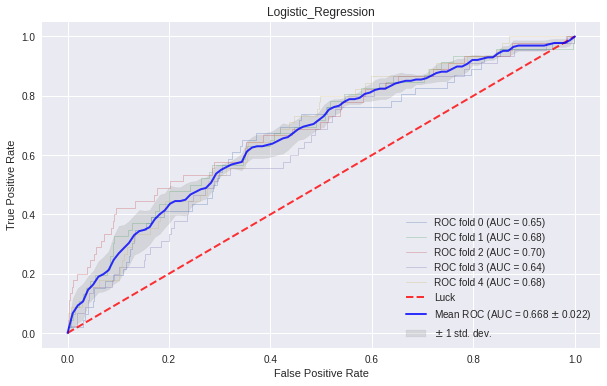

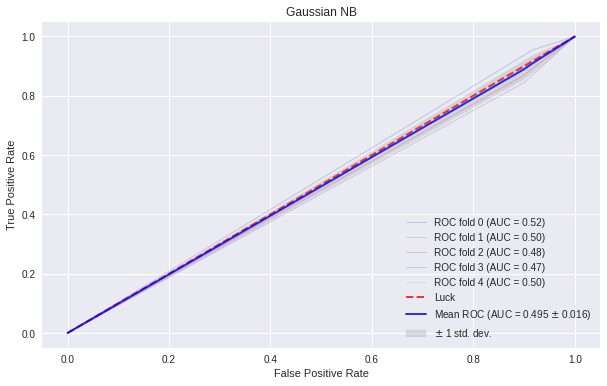

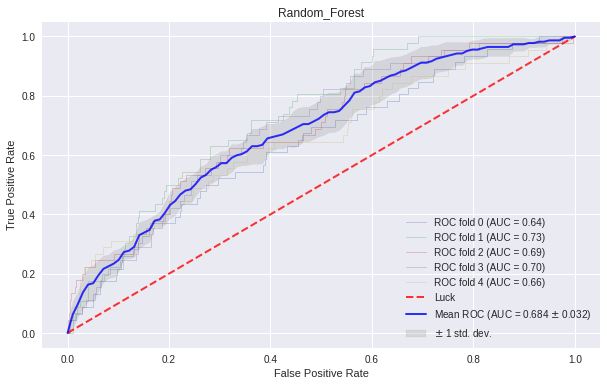

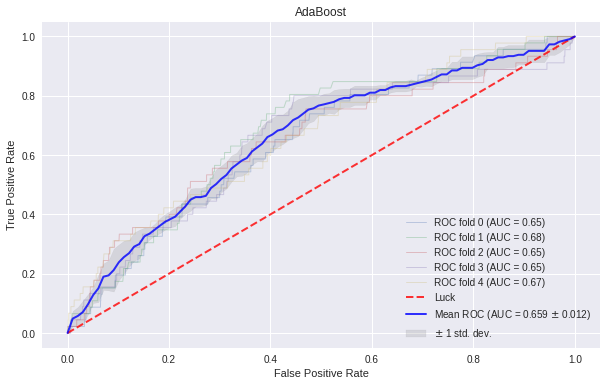

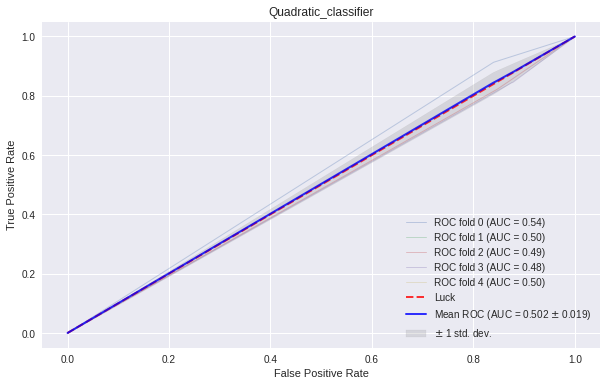

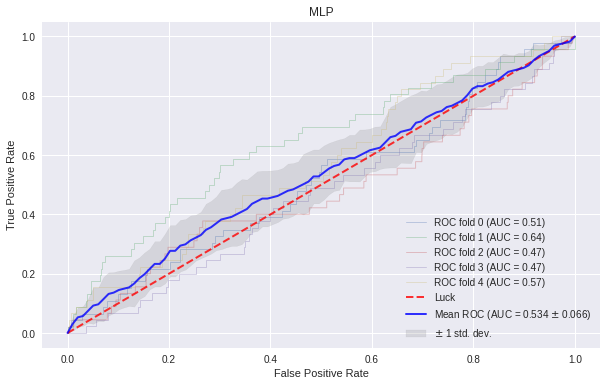

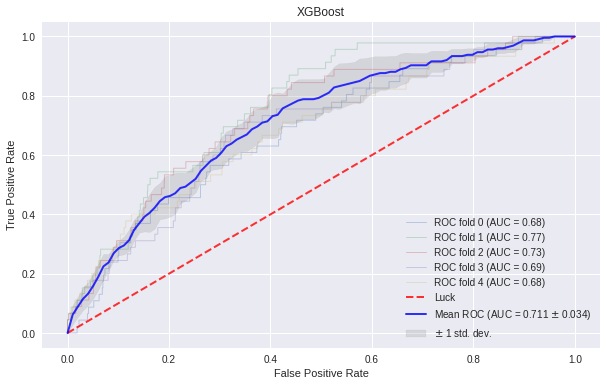

In [35]:
##### Run complete k-fold validation for second train

# initializing variables for K-fold validation
splits = 5
repeats = 3
classifiers_to_compute = {'Logistic_Regression': clf_1_tuned, 'Gaussian NB': clf_2, 'Random_Forest': clf_3_tuned_lasso, 
                          'AdaBoost': clf_4_tuned,'Quadratic_classifier': clf_5, 'MLP': clf_6_tuned, 'XGBoost': clf_7_tuned_lasso}


# initializaing K-fold validation
kfolds = RepeatedStratifiedKFold(n_splits = splits, n_repeats=repeats, random_state = seed)

metric_store_tuned = [] # store classifier metrics
scores_tuned = [] # store UAC score results from k-fold validation

for idx,clf in enumerate(classifiers_to_compute):
    
    roc_curve_inputs = {}
    fprs = [] 
    tprs = []
    
    for (train, test), i in zip(kfolds.split(X_train_lasso, y_train_lasso), range(splits)):
        
        classifiers_to_compute[clf].fit(X_train_lasso.iloc[train], y_train_lasso.iloc[train])
        _, _, auc_score_train, _ = compute_roc_auc_dense(classifiers_to_compute[clf], clf, train)
        fpr, tpr, auc_score, metrics = compute_roc_auc_dense(classifiers_to_compute[clf], clf, test)
        
        scores_tuned.append((auc_score_train, auc_score, clf))
        fprs.append(fpr)
        tprs.append(tpr)
        metric_store_tuned.append(metrics)
    
    plot_roc_curve(fprs, tprs, clf)

In [36]:
# Define dfs with k-fold validation results for the first train
confusion_matrix_scores_lasso_train = pd.DataFrame(metric_store_tuned, columns = ['classifier','auc', 'accuracy', 'recall', 'precision', 'f1'])
final_scores_K_fold_lasso_train =  pd.DataFrame(scores_tuned, columns=['AUC Train', 'AUC Test', 'classifier'])

# export to csv
for df in [('confusion_matrix_scores_lasso_train',confusion_matrix_scores_lasso_train), 
           ('final_scores_K_fold_lasso_train',final_scores_K_fold_lasso_train)]:
    df[1].to_csv(path_tuning + df[0]+'.csv', index = True, index_label = False)

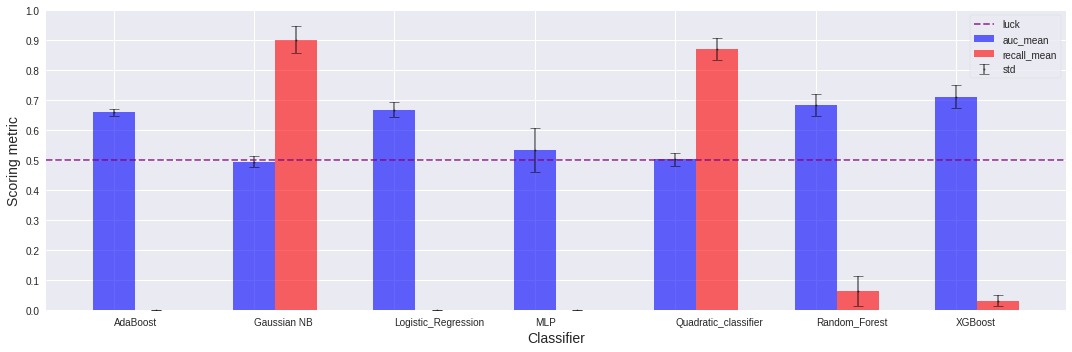

In [37]:
### Set up for plotting
fig, axs = plt.subplots(1,1, figsize=(15, 5)) # Create figure and axes
    
# Define df to plot
confusion_matrix_scores_lasso_train = pd.read_csv(path_tuning + 'confusion_matrix_scores_lasso_train.csv')
classfiers_second_train = confusion_matrix_scores_lasso_train.groupby(['classifier'], as_index=False).agg(['mean','std']).reset_index().droplevel(1, axis=1)
classfiers_second_train.columns = ['classifier','auc_mean', 'auc_std', 'acc_mean', 'acc_std', 'recall_mean', 'recall_std', 'pre_mean', 'pre_std', 'f1_mean', 'f1_std']

                
x1_pos = np.arange(len(classfiers_second_train))
x2_pos = [x+bar_width for x in x1_pos]
x_axis = classfiers_second_train['classifier'].unique().tolist()
baseline = 0.5

auc_mean = classfiers_second_train.iloc[:,1]
auc_std = classfiers_second_train.iloc[:,2]
recall_mean = classfiers_second_train.iloc[:,5]
recall_std = classfiers_second_train.iloc[:,6]
                        
axs.bar(x1_pos, auc_mean, color= colors['c1'][0], label = 'auc_mean', width = bar_width, alpha = 0.6)
axs.bar(x2_pos, recall_mean, color = colors['c1'][1], label = 'recall_mean', width = bar_width, alpha = 0.6)
axs.errorbar(x1_pos, auc_mean, auc_std, fmt='.', color = 'black', label = 'std' , capthick=1, alpha=0.5, ms=4, capsize=5)
axs.errorbar(x2_pos, recall_mean, recall_std, fmt='.', color = 'black', capthick=1, alpha=0.5, ms=4, capsize=5)
axs.axhline(y=baseline, xmin = min(x1_pos), xmax = max(x1_pos),color = colors['c2'][3],label = 'luck' ,alpha=0.75, linestyle = '--' )

# Plot configuration
axs.set_xticks(x1_pos)
axs.set_xlabel('Classifier', fontsize = size['label']) # xlabel name
axs.set_ylabel('Scoring metric', fontsize = size['label']) # ylabel name
axs.legend(loc = 'upper right', frameon = True)
axs.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
axs.set_yticks(np.arange(0, 1.1, 0.1))
axs.set_xticklabels(x_axis, rotation = 0, fontsize = size['tick'], horizontalalignment = 'left')
axs.tick_params(axis = 'both', which = 'major', labelsize = size['tick'])


plt.tight_layout(w_pad=2.5, h_pad=0.1)
plt.show()

### 5.2 Model generalization

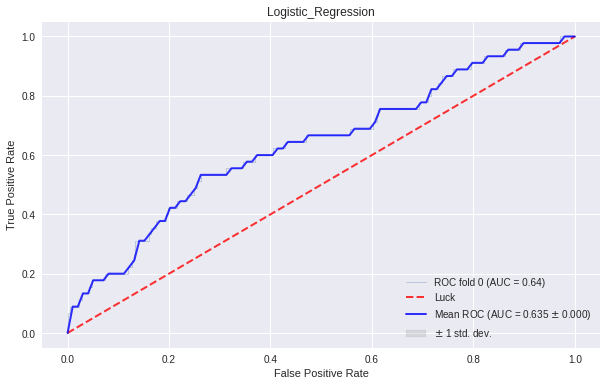

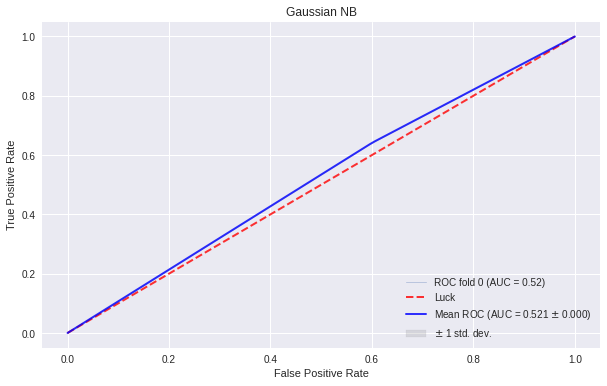

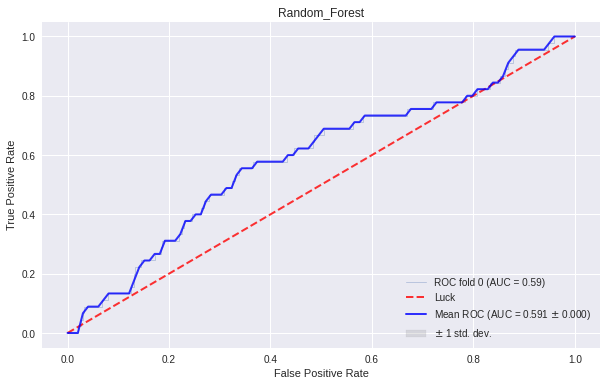

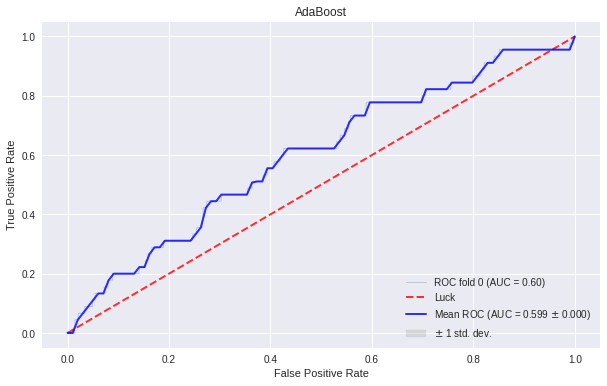

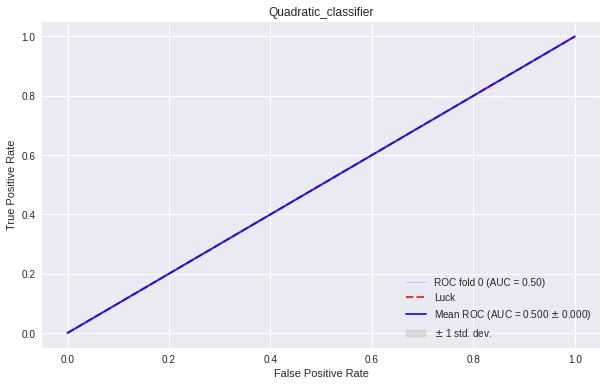

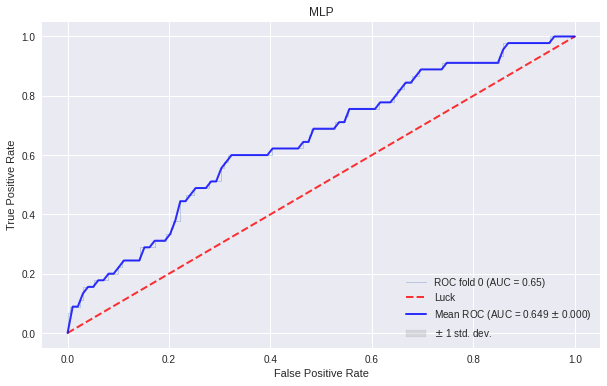

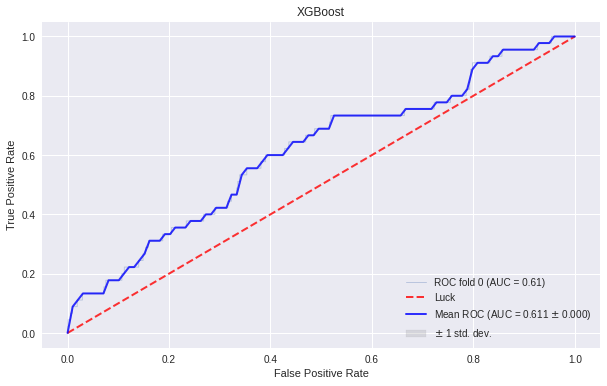

In [47]:
##### Run complete k-fold validation for thrid train

# initializing classifier list
classifiers_to_compute =  {'Logistic_Regression': clf_1_tuned, 'Gaussian NB': clf_2, 'Random_Forest': clf_3_tuned_lasso, 
                          'AdaBoost': clf_4_tuned,'Quadratic_classifier': clf_5, 'MLP': clf_6_tuned, 'XGBoost': clf_7_tuned_lasso}

metric_store_test = [] # store classifier metrics

for idx,clf in enumerate(classifiers_to_compute):

    roc_curve_inputs = {}
    fprs = [] 
    tprs = []

    classifiers_to_compute[clf].fit(X_test_lasso, y_test_lasso)
    fpr, tpr, auc_score, metrics = compute_roc_auc_dense(classifiers_to_compute[clf], clf, test)
    fprs.append(fpr)
    tprs.append(tpr)
    metric_store_test.append(metrics)


    plot_roc_curve(fprs, tprs, clf)

In [48]:
# Define dfs with k-fold validation results for the first train
confusion_matrix_scores_lasso_test = pd.DataFrame(metric_store_test, columns = ['classifier','auc', 'accuracy', 'recall', 'precision', 'f1'])

# export to csv
for df in [('confusion_matrix_scores_lasso_test',confusion_matrix_scores_lasso_test)]:
    df[1].to_csv(path_tuning + df[0]+'.csv', index = True, index_label = False)

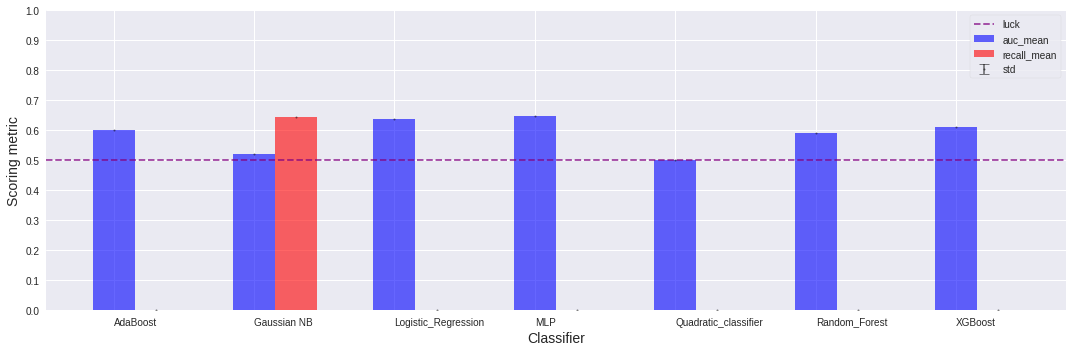

In [49]:
### Set up for plotting
fig, axs = plt.subplots(1,1, figsize=(15, 5)) # Create figure and axes
    
# Define df to plot
confusion_matrix_scores_lasso_test = pd.read_csv(path_tuning + 'confusion_matrix_scores_lasso_test.csv')
classfiers_test = confusion_matrix_scores_lasso_test.groupby(['classifier'], as_index=False).agg(['mean','std']).reset_index().droplevel(1, axis=1)
classfiers_test.columns = ['classifier','auc_mean', 'auc_std', 'acc_mean', 'acc_std', 'recall_mean', 'recall_std', 'pre_mean', 'pre_std', 'f1_mean', 'f1_std']

                
x1_pos = np.arange(len(classfiers_test))
x2_pos = [x+bar_width for x in x1_pos]
x_axis = classfiers_test['classifier'].unique().tolist()
baseline = 0.5
# baseline_rec = results_base_df.iloc[2][0]

auc_mean = classfiers_test.iloc[:,1]
auc_std = classfiers_test.iloc[:,2]
recall_mean = classfiers_test.iloc[:,5]
recall_std = classfiers_test.iloc[:,6]
                        
axs.bar(x1_pos, auc_mean, color= colors['c1'][0], label = 'auc_mean', width = bar_width, alpha = 0.6)
axs.bar(x2_pos, recall_mean, color = colors['c1'][1], label = 'recall_mean', width = bar_width, alpha = 0.6)
axs.errorbar(x1_pos, auc_mean, auc_std, fmt='.', color = 'black', label = 'std' , capthick=1, alpha=0.5, ms=4, capsize=5)
axs.errorbar(x2_pos, recall_mean, recall_std, fmt='.', color = 'black', capthick=1, alpha=0.5, ms=4, capsize=5)
axs.axhline(y=baseline, xmin = min(x1_pos), xmax = max(x1_pos),color = colors['c2'][3],label = 'luck' ,alpha=0.75, linestyle = '--' )

# Plot configuration
axs.set_xticks(x1_pos)
axs.set_xlabel('Classifier', fontsize = size['label']) # xlabel name
axs.set_ylabel('Scoring metric', fontsize = size['label']) # ylabel name
axs.legend(loc = 'upper right', frameon = True)
axs.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
axs.set_yticks(np.arange(0, 1.1, 0.1))
axs.set_xticklabels(x_axis, rotation = 0, fontsize = size['tick'], horizontalalignment = 'left')
axs.tick_params(axis = 'both', which = 'major', labelsize = size['tick'])


plt.tight_layout(w_pad=2.5, h_pad=0.1)
plt.show()

# Appendix

# Reference

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/